# Kaggle Leaf Classification Challenge


In [1]:
## Install pandas if you don't already have it (uncomment line below)

# ! pip install pandas
#! pip install utils
#! pip install -U requests

In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize


In [3]:
from PIL import Image, ImageOps
from skimage.io import imread
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
import warnings
def pad2square(img):
    img_shape = img.shape
    r = img_shape[0]
    c = img_shape[1]
    new_side = np.max([r,c])
    padding = ((new_side - c)//2, (new_side - r)//2, int(np.ceil((new_side - c)/2)), int(np.ceil((new_side - r)/2)))
    img_as_img = Image.fromarray(img)
    new_img = ImageOps.expand(img_as_img, padding)
    return np.array(new_img)


# Tying everything together

Now that you have learned about the most common network architectures, it is time to combine them into a more advanced model. 
It often happens that you have a combination of data that cannot easily be modeled by any single one of these types of network. Knowing how to divide the data into the right subsets, and then build a network that handles each subset efficiently can mean the difference between a great model and an unusable one. 

In this notebook, we will work on the **Kaggle Leaf Classification Challenge**, a data science competition from [`kaggle.com`](https://www.kaggle.com/) that contains several different kinds of data.
We will download the data, visualize it, and train a classifier.
A simple network with poor performance is provided for you as a starting point, but it is up to you use what you have learnt to improve the results.


## Kaggle challenge

Kaggle is a website to participate in real-world challenges.
Most competitions on Kaggle have a dataset, an accuracy metric and a leaderboard to compare submissions.
You can read more about Kaggle public datasets [here](https://www.kaggle.com/datasets).

We will undertake the [_Leaf Classification_](https://www.kaggle.com/c/leaf-classification) challenge. We report here the description of the dataset:

> The dataset consists of approximately 1,584 images of leaf specimens which have been converted to binary black leaves against white backgrounds. 
Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.


# Get set up

**NB**: You will need a Kaggle account for this exercise!

1. Go to [Kaggle](https://www.kaggle.com/), create an account
2. [Download the dataset](https://www.kaggle.com/c/leaf-classification/data)
3. Unpack the dataset in the current directory. Structure should be as follows:
```
02456-deep-learning-with-PyTorch\4_Mini_Project
--> sample_submission.csv
--> test.csv
--> train.csv
--> images
--> --> 1.jpg
--> --> 2.jpg
--> --> 3.jpg
--> --> ...
```

# Upload data to colab
If you're running this notebook on google colab, you'll need to upload `data_utils.py` that we provide as well as the data you've just downloaded from kaggle to colab. Small files like `data_utils.py` you can simply upload via the folder icon to the left. Files that are uploaded like this, however, will be deleted every time the session ends. For big files like the kaggle data folder it's therefore better to:

1. upload the data to google drive
2. mount the google drive (see cell below)

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

After going through a quick authorization process you should now have access to the uploaded file via colab. We can check the location of our data as follows:

In [5]:
#!ls drive/'My Drive'

Let's save the path for later use. Just replace this with your local path if you're not running on colab.

In [6]:
#drive_path = 'drive/My Drive/Kaggle/'
# local_path = ''  # if you're folder structure is as defined above and you want to run locally

# Visualizing the data

First we start out by looking at the images. 
You need to load them first!
Then we load in the training data, which is in CSV format. For this, we use [pandas](https://pandas.pydata.org/).
Pandas is useful for data analysis, but we don't suggest using it in any production code.

In [7]:
image_paths = glob.glob("images/*.jpg")
print("Total Observations:\t", len(image_paths))
#https://drive.google.com/drive/folders/1s-xqME9bboreokc0eIdBDZtkPoQV_LgT?usp=sharing

# now loading the train.csv to find features for each training point
train = pd.read_csv('train.csv')
train_images = ['images/{}.jpg'.format(i) for i in train.id.values]

# now loading the test.csv
test = pd.read_csv('test.csv')

Total Observations:	 1584


images/8.jpg


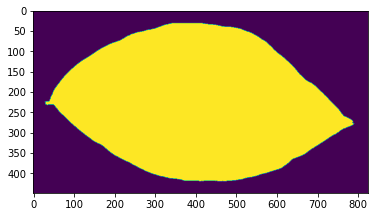

In [8]:
idx = 5
len(train_images)
print(train_images[idx])
image = imread(train_images[idx])
plt.imshow(image)

## Exercise 1

1.1) How many samples do we have for training and test? Do we have the same information for training and test data? How many samples do we have for each species?

**Hint**: You might want to use .shape, .columns, pd.unique() and .symmetric_difference().


**Answer**:

* The code below shows the first 5 rows of the train and test data in detial. In addition, the sizes of the sets is also summarized at the end.

In [9]:
train.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [10]:
test.head()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,12,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,13,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812


In [11]:
print(f"train: {train.shape[1]} features (columns)")
print(f"train: {train.shape[0]} samples (rows)")
print(f"test: {test.shape[1]} features (columns)")
print(f"test: {test.shape[0]} samples (rows)\n")

unique, counts = np.unique(np.array(train.species),return_counts = True)
print(f"unique species: {len(unique)}")
print(f"samples per species: {counts}\n")

train_col = train.columns
test_col = test.columns
print(f"difference between tables is: {train_col.difference(test_col)[0]}")


train: 194 features (columns)
train: 990 samples (rows)
test: 193 features (columns)
test: 594 samples (rows)

unique species: 99
samples per species: [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10]

difference between tables is: species


With our training data and images loaded into memory.
It is time to take a look at the data.
Trying to classify leaves does not sound like a particularly difficult or interesting problem.
We have probably all had teachers forcing us to do it on field trips as children.

But try to take a look at **all** the different categories and come up with a system that discerns **all** types of leaves from each other. (In fact, distinguishing crops from weed using AI is already a thing: [weed-killing AI](https://www.cnbc.com/2018/06/04/weed-killing-ai-robot.html).)

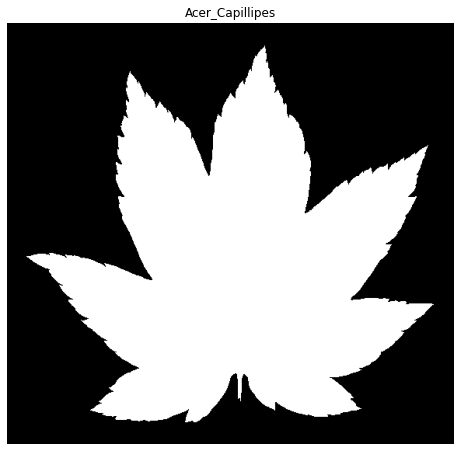

In [12]:
drive_path = ''

# First we find an example of each species in order to visualize it
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

# Then we gather its index in our list of images in order to find the correct image
indexes = [image_paths.index(drive_path + 'images\\{}.jpg'.format(i)) for i in species_examples]

# Display the first image
plt.figure(figsize=(8, 8))
image = imread(image_paths[indexes[1]], as_gray=True)
plt.imshow(image, cmap='gray')
plt.title("%s" % (species[0]))
plt.axis('off')
plt.show()

## Exercise 2
2.1) In general it is a good approach to visualize an image for each category to get a better feeling of the task. You should now write some code to show 1 image from each category. You might want to use plt.subplot().

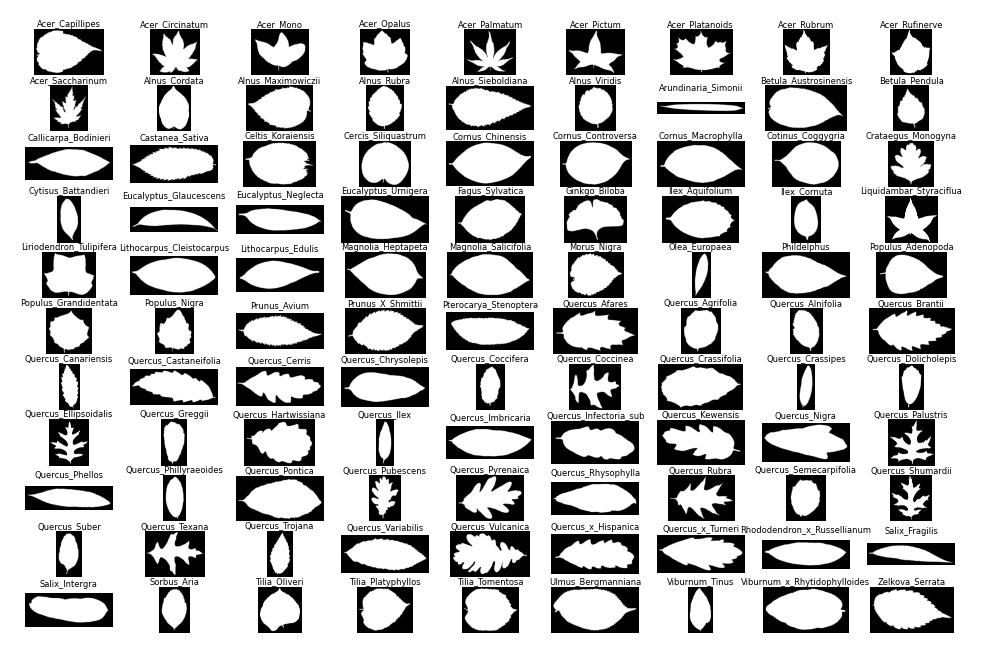

In [13]:
# Now plot 1 image from each category

rows = 11
columns = 9

fig, ax = plt.subplots(nrows=rows, ncols=columns, dpi=200)
for r in range(rows):
    for c in range(columns):
        image = imread(image_paths[indexes[r*columns + c]], as_gray=True)
        ax[r][c].imshow(image, cmap='gray')
        ax[r][c].set_title("%s" % (species[r*columns + c]), fontsize=3, y=0.7)
        ax[r][c].axis('off')

As you can see, classifying leaves is actually a very tough problem.
What makes it even worse is that we cannot use all the image data we have available.
In order to decrease the amount of computation needed, we need to reduce the size of the images as much as possible.
On top of that, our neural network usually only accepts fixed-size input tensors.
This means we will have to change the shape of the images so that they all have the same sizes.


Resizing is problematic because it alters the shape of the leaves, and for some of them, this is their most distinctive feature. Take a look at `Salix_Intergra` in the bottom left corner.
Describing this leaf without taking its shape into account seems extremely difficult.

Therefore we will 
1. first pad all the images into squares, and
2. then resize them.

## Exercise 3

3.1) **Find an appropriate image size**. Test various resizings of the image until you have found the smallest resizing of the image where you "can still differentiate between the images".
How small is too small should ultimately be determined by an actual test, but what makes sense visually is probably a good place to start.
Change the `image_size = (?, ?)` parameter below, and note your choice.

 * At a resolution of 45x45 pixels, the edges are still clearly visible and distinguishable. Going smaller starts the degrade the images.
 * I also tried 30x30 and 38x38, but they both resulted in worse Kaggle scores.


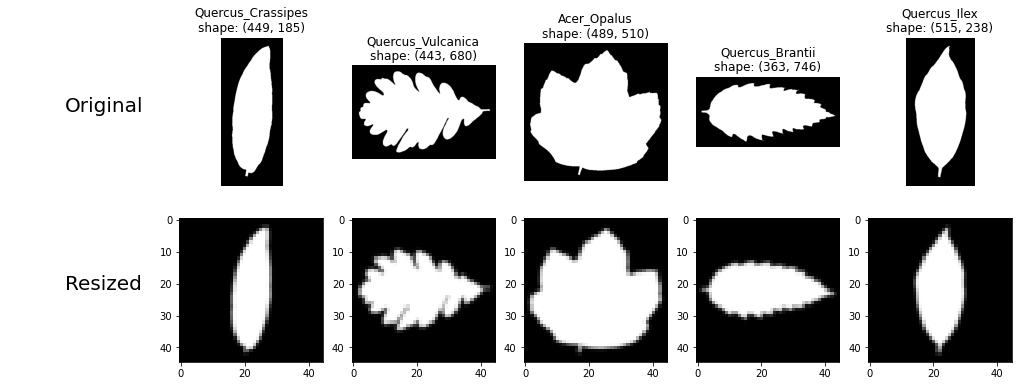

In [14]:
## Image pre-processing
image_size = (45, 45)  # <-- YOUR CODE HERE

# Amount of images
amount = 5
image_sample = np.random.choice(train_images, amount)

# Define figure size
fig = plt.figure(figsize=(18, 6))

# Save original images in the figure
ax = plt.subplot(2, amount + 1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)
    image = imread(path, as_gray=True)    
    plt.imshow(image, cmap='gray')
    _id = int(path.split('/')[-1].split('.')[0])
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')
    
# Save resized images in the figure
ax = plt.subplot(2, amount + 1, len(image_sample) + 2)
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3
    plt.subplot(2, amount + 1, i)
    image = imread(path, as_gray=True)
    image = pad2square(image)  # Make the image square
    image = resize(image, output_shape=image_size, mode='reflect', anti_aliasing=True)  # resizes the image
    plt.imshow(image, cmap='gray')

# Show plot
plt.show()

## Investigating the other features

Now that we have looked at the image data we have available, it is time to take a look at the other available features. Below we choose a random subset of the training data, and visualize the 3 types of available features:
* margin
* shape
* texture

Run it a few times to try and get an understanding of how the features differ from species to species.

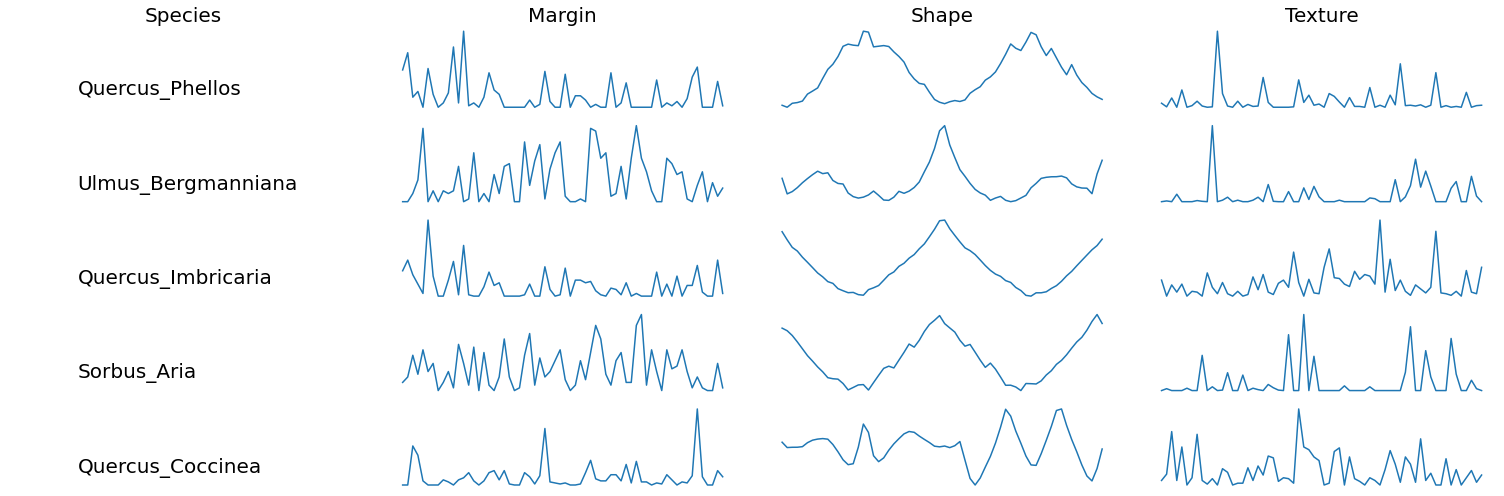

In [15]:
# Extract features
X = train.values
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# Let us plot some of the features
plt.figure(figsize=(21,7)) # Set the plot size
amount = 5                 # Choose the amount of images we want to show at a time

for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    ax = plt.subplot(amount,4,1+i*4)
    txt = ax.text(0.2, 0.2, species[idx][0], fontsize=20)
    txt.set_clip_on(False)
    plt.axis('off')
    if i == 0:
        plt.title('Species', fontsize=20)
    plt.subplot(amount,4,2+i*4)
    plt.plot(margin[idx])
    if i == 0:
        plt.title('Margin', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,3+i*4)
    plt.plot(shape[idx])
    if i == 0:
        plt.title('Shape', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,4+i*4)
    plt.plot(texture[idx])
    if i == 0:
        plt.title('Texture', fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Exercise 4
So far we have learned about feed forward neural networks (FFNN), convolutional neural networks (CNN), recurrent neural networks (RNN), and transformers.

4.1) How could the `image`, `Margin`, `Shape` and `Texture` be used for classification, i.e. what kind of network type would you use for each of them, and why?

**Answer**:

 - the `image` alone could be used in a CNN, together with a FFNN to create a classifier
 - `margin`, `shape`, and `texture`could be used a simple FFNN for classification, but given the similarities between some species, the accuracy would probably be low
 - ultimately, combining all the information in a more complex system, such as the one below, with a CNN, and RNN and a FFNN should give a better classifier

# Managing the data

The details of the code in this section isn't that important.
It simply manages the data in a nice way - so it is a good place to come back and look for inspiration when you will work on your own projects.


## Defining the data loader

## Exercise 5 
5.1) As a part of the data loader, we should specify the shape of the images, number of classes, and the number of features for the three feature types: margin, shape and texture. Define the three variables in the code below.

In [16]:
class load_data():
    # data_train, data_test and le are public
    def __init__(self, train_path, test_path, image_paths, image_shape=(128, 128)):
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)
        image_paths = image_paths
        image_shape = image_shape
        self._load(train_df, test_df, image_paths, image_shape)
        
    def _load(self, train_df, test_df, image_paths, image_shape):
        # load train.csv
        path_dict = self._path_to_dict(image_paths) # numerate image paths and make it a dict
        # merge image paths with data frame
        train_image_df = self._merge_image_df(train_df, path_dict)
        test_image_df = self._merge_image_df(test_df, path_dict)
        # label encoder-decoder (self. because we need it later)
        self.le = LabelEncoder().fit(train_image_df['species'])
        # labels for train
        t_train = self.le.transform(train_image_df['species'])
        # getting data
        print("Loading training data")
        train_data = self._make_dataset(train_image_df, image_shape, t_train)
        print("Loading test data")
        test_data = self._make_dataset(test_image_df, image_shape)        
        # need to reformat the train for validation split reasons in the batch_generator
        self.train = self._format_dataset(train_data, for_train=True)
        self.test = self._format_dataset(test_data, for_train=False)
        

    def _path_to_dict(self, image_paths):
        path_dict = dict()
        for image_path in image_paths:
            num_path = int(os.path.basename(image_path[:-4]))
            path_dict[num_path] = image_path
        return path_dict

    def _merge_image_df(self, df, path_dict):
        split_path_dict = dict()
        for index, row in df.iterrows():
            split_path_dict[row['id']] = path_dict[row['id']]
        image_frame = pd.DataFrame(list(split_path_dict.values()), columns=['image'])
        df_image =  pd.concat([image_frame, df], axis=1)
        return df_image
        
    def _make_dataset(self, df, image_shape, t_train=None):
        # make dataset
        data = dict()
        # merge image with 3x64 features
        for i, dat in enumerate(df.iterrows()):
            index, row = dat
            sample = dict()
            if t_train is not None:
                features = row.drop(['id', 'species', 'image'], axis=0).values
            else:
                features = row.drop(['id', 'image'], axis=0).values
            sample['margin'] = features[:64]
            sample['shape'] = features[64:128]
            sample['texture'] = features[128:]
            if t_train is not None:
                sample['t'] = np.asarray(t_train[i], dtype='int32')
            image = imread(row['image'], as_gray=True)
            image = pad2square(image)
            image = resize(image, output_shape=image_shape, mode='reflect', anti_aliasing=True)
            image = np.expand_dims(image, axis=2)
            sample['image'] = image   
            data[row['id']] = sample
            if i % 100 == 0:
                print("\t%d of %d" % (i, len(df)))
        return data

    def _format_dataset(self, df, for_train):
        # making arrays with all data in, is nessesary when doing validation split
        data = dict()
        value = list(df.values())[0]
        img_tot_shp = tuple([len(df)] + list(value['image'].shape))
        data['images'] = np.zeros(img_tot_shp, dtype='float32')
        feature_tot_shp = (len(df), 64)
        data['margins'] = np.zeros(feature_tot_shp, dtype='float32')
        data['shapes'] = np.zeros(feature_tot_shp, dtype='float32')
        data['textures'] = np.zeros(feature_tot_shp, dtype='float32')
        if for_train:
            data['ts'] = np.zeros((len(df),), dtype='int32')
        else:
            data['ids'] = np.zeros((len(df),), dtype='int32')
        for i, pair in enumerate(df.items()):
            key, value = pair
            data['images'][i] = value['image']
            data['margins'][i] = value['margin']
            data['shapes'][i] = value['shape']
            data['textures'][i] = value['texture']
            if for_train:
                data['ts'][i] = value['t']
            else:
                data['ids'][i] = key
        return data

    

In [17]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE = (45, 45, 1) # <-- Your answer here
NUM_CLASSES = 99

# For all three features types margin, shape, and texture, we have NUM_FEATURES for each type.
NUM_FEATURES = 4 

In [ ]:
'''
# Paths to data
TRAIN_PATH = drive_path + "train.csv" 
TEST_PATH = drive_path + "test.csv" 
IMAGE_PATHS = glob.glob(drive_path + "images/*.jpg")

# train holds both X (input) and t (target/truth)
data = load_data(train_path=TRAIN_PATH, 
                test_path=TEST_PATH,
                image_paths=IMAGE_PATHS,
                image_shape=IMAGE_SHAPE[:2])
# to visualize the size of the dimensions of the data
print("\n@@@Shape checking of data sets@@@")
print("TRAIN")
print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
print("\tts\t %s" % (data.train['ts'].shape))
print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
print("TEST")
print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
print("\tids\t%s" % (data.test['ids'].shape))
'''

#### Do you want to load your data quickly next time?
In the above cell the data is loaded, reshaped and stored as an object. If you want load this object quickly next time you should go for pickle. Pickle does effectively write an object into a character stream, so it can be loaded fastly next time. Simply replace `drive_path` with you `local_path` if you're not using colab. 

In [33]:
#import pickle

# Dump the data into a pickle file
#with open(drive_path + f'data_{IMAGE_SHAPE[0]}.pickle', 'wb') as f:
#    pickle.dump(data, f)

In [19]:
import pickle

# Load the data from a pickle file
with open(drive_path + f'data_{IMAGE_SHAPE[0]}.pickle', 'rb') as f:
    data = pickle.load(f)

## Batch Generator

While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.

## Exercise 6
6.1) Explain shortly why the size of batches is important. You should comment on how the size of batches affect the memory, training speed, and the estimates of the gradients.
Choose a reasonable batch size the `batch_size = 18 ` parameter below, and note your choice.

 * the larger the batch size, the faster an epoch is finished by the network, but it also requires a bigger memory.
 * larger batch sizes could have a negative impact on the generalization of the network
 
 * a small batch size is good for generalization, but it affects the runtime and also the gradient converges much slower, as every output is more random compared to each other
 
* by trial and error, I have selected 25 as the batch size

In [20]:
from data_utils import batch_generator

batch_size = 25
dummy_batch_gen = batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))

TRAIN
	images, (25, 45, 45, 1)
	margins, (25, 64)
	shapes, (25, 64)
	textures, (25, 64)
	ts, (25, 99)

VALID
	images, (25, 45, 45, 1)
	margins, (25, 64)
	shapes, (25, 64)
	textures, (25, 64)
	ts, (25, 99)

TEST
	images, (25, 45, 45, 1)
	margins, (25, 64)
	shapes, (25, 64)
	textures, (25, 64)
	ids, 25


# Build the model

In [21]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [22]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


## Exercise 7
7.1)  Now you must define the network architecture. It is always a good idea to start simple. We recommend you to start with a mix of a convolutional layer (maybe followed by max pooling layer), a recurrent layer, and a linear output layer such that we use all the features.  

When you build the model you should be aware of the dimensions of the input and output for your different layers. The function`permute` and `view` will be very useful to rearrange your dimensions.

In [23]:
num_classes = len(train.species.unique())
CNN_channels = [1, 10, 20]
  
class Net(nn.Module):
    def __init__(self, CNN_channels, output_size):
        super(Net, self).__init__()
        
        # Set activation function for easy adaption
        self.activation = nn.ReLU()
        
        self.cnn_1 = nn.Sequential(nn.BatchNorm2d(CNN_channels[0], eps=1e-05, momentum=0.4),
                                 nn.Dropout(0.1),
                                 nn.Conv2d(CNN_channels[0], CNN_channels[1], 3, stride=2),
                                 self.activation,
                                 
                                 nn.BatchNorm2d(CNN_channels[1], eps=1e-05, momentum=0.4),
                                 nn.Dropout(0.1),
                                 nn.MaxPool2d(2, ceil_mode=True),
                                 
                                 nn.BatchNorm2d(CNN_channels[1], eps=1e-05, momentum=0.4),
                                 nn.Dropout(0.1),
                                 nn.Conv2d(CNN_channels[1], CNN_channels[2], 3),
                                 
                                 nn.BatchNorm2d(CNN_channels[2], eps=1e-05, momentum=0.4),
                                 nn.Dropout(0.1),
                                 nn.MaxPool2d(2, ceil_mode=True)                                
                                )
        # Exercise: Add a recurrent unit like and RNN or GRU
        self.rnn_1 = nn.GRU(1, 10, 20, dropout=0.3)
        
        self.fcl_1 = nn.Sequential(nn.BatchNorm1d(num_features=404),
                                  Linear(in_features = 404, out_features=256), 
                                  nn.BatchNorm1d(num_features=256),
                                  nn.Dropout(0.2),
                                  Linear(in_features = 256, out_features=128),
                                  nn.BatchNorm1d(num_features=128),
                                  nn.Dropout(0.2),
                                  Linear(in_features = 128, out_features=output_size))
        self.softmax = torch.nn.Softmax(dim=0)
        
    
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        ## Convolutional layer ##
        # - Change dimensions to fit the convolutional layer 
        # - Apply Conv2d
        # - Use an activation function
        # - Change dimensions s.t. the features can be used in the final FFNN output layer
        batches, w, h, ch = x_img.shape
        x_img = x_img.view(batches,ch,w,h)
        
        # Process the image in a CNN:
        features_img = self.cnn_1(x_img)
        
        # Reshape manually to fit dimensions
        features_img = features_img[:,:,0,0]
        
        # Append features to the list "features"
        features.append(features_img)
        
        ## Use concatenated leaf features for FFNN ##
        features_vector = torch.cat((x_margin, x_shape, x_texture), dim=1) 
        features.append(features_vector)
        
        ## Use concatenated leaf features for RNN ##
        # - Chage dimensions to fit GRU
        # - Apply GRU
        # - Change dimensions s.t. the features can be used in the final FFNN output layer
        features_rnn = self.rnn_1(features_vector.unsqueeze(-1))
        features_rnn = torch.cat(features_rnn)
        features_rnn = features_rnn[0:batches,:,0]
        
        # Append features to the list "features"
        features.append(features_rnn)

        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim = 1)        
        features_final = features_final.reshape(features_final.size(0), -1)
        tmp = self.fcl_1(features_final)
        out['out'] = self.softmax(tmp)
        return out

net = Net(CNN_channels, num_classes)
if use_cuda:
    net.cuda()
print(net)

Net(
  (activation): ReLU()
  (cnn_1): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.4, affine=True, track_running_stats=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): Conv2d(1, 10, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.4, affine=True, track_running_stats=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (7): BatchNorm2d(10, eps=1e-05, momentum=0.4, affine=True, track_running_stats=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(20, eps=1e-05, momentum=0.4, affine=True, track_running_stats=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (rnn_1): GRU(1, 10, num_layers=20, dropout=0.3)
  (fcl_1): Sequential(
    (0): BatchNorm1d(404, eps=1e-05, momentum=0.1, affine=T

# Build the cost function

## Exercise 8
8.1) Since this is a classification task we will use the cross-entropy loss. Define the cross-entropy loss as the loss function in the code below.

In [24]:
LEARNING_RATE = 0.001
DECAY = 1e-3
criterion = nn.CrossEntropyLoss()      # <-- Your code here.   

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=DECAY)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

# Train

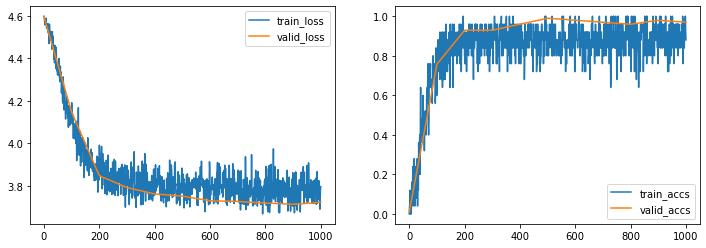

In [25]:
# Setup settings for training 
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
max_iter = 1000
log_every = 100
eval_every = 100

# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images']))),
        'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
        'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
        'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
    }

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen = batch_generator(data,
                            batch_size=batch_size,
                            num_classes=NUM_CLASSES,
                            num_iterations=max_iter,
                            seed=42,
                            val_size=VALIDATION_SIZE)

# Train network
net.train()
for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:
        
        # Do the validaiton
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
#         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
        net.train()
    
    # Train network
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)
    
    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    # Log i figure
    if i % log_every == 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.plot(valid_iter, valid_loss, label='valid_loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.plot(valid_iter, valid_accs, label='valid_accs')
        plt.legend()
        plt.show()
        clear_output(wait=True)
#         print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
        
    if max_iter < i:
        break

In [26]:
print('Training accuracy:', train_accs[-1])
print('Validation accuracy:', float(valid_accs[-1]))

Training accuracy: 0.8799999952316284
Validation accuracy: 0.9696969985961914


## Exercise 9

**Tip** This is a very small dataset (number of observations) compared to the number of features.
This means that overfitting may be an issue, and sometimes fancy tricks won't do any good. 
Keep that in mind, and always start simple.

**3.1) Improve the network**, and get as high a validation score as you can. 
When trying to improve the network nothing is sacred. You can try various learning rates, batch sizes, validation sizes, etc. 
And most importantly, the validation set is very small (only 1 sample per class), etc.

To get you off to a good start we have created a list of **things you might want to try**:
* Add more layers (mostly fully connected and convolutional)
* Increase or decrease the batch size 
* Use dropout (a lot - e.g. between the convolutional layers)
* Use batch normalization (a lot)
* Try with L2 regularization (weight decay)
* Use only the image for training (with CNN) - comment on the increased time between iterations.
* Change the image size to be bigger or smaller
* Try other combinations of FFN, CNN, RNN parts in various ways (bigger is not always better)

If your network is not performing as well as you would like it to, [here](http://theorangeduck.com/page/neural-network-not-working) is a great explanation of what might have gone wrong.


**3.2) Improve Kaggle score**. Once happy try to get the best score on Kaggle for this dataset as you can (**upload** instructions below)
You can upload your solution multiple times as you progress.
A very good implementation would get a score between $0.04$ to $0.06$ (the smaller the better), try and see if you can get there, and explain what might have gone wrong if you can't. 


**3.3) Reflect on the process**, and how you got to your final design and discuss your final results. 
What worked, and what didn't?
Include at least the following: 
* Description of the final architecture
* Description of the training parameters
* Description of the final results (Kaggle and validation)

**Answer:**

On the final architecture:<br>
I have included quite regular batch normalizations and dropout layers, where I have also tuned a bit the parameters to get to where it is now.

On the training parameters:<br>
First I tried different image sizes: 30x30, 38x38 and 45x45, and, as expected, the 45x45 results in the best score with all other parameters fixed. This I explain by the cleaner edges in the images.
Next I played around with the batch size, trying 10, 18, and finally 25 images per batch. The last reulted in the best scores.

Other parameters I tried:
- CNN layers [1, 20, 40], [1, 10, 20, 40], [1, 30, 60], [1, 20, 40]
- FFNN layers [512, 256, 128], [512, 256, 128], [512, 256, 128, 64], [256, 128]
- Kaggle scores: 1.9, 2.4, 1.9, 1.6 - not good, but ultimately I understood on my own skin that larger architectures are not always better. 
- In general, the validation accuracy ranged between 0.94 and 0.97 for all architectures.
- During training, the validation accuracy gets close to 1, so there is more than likely some overfitting going on.


In [31]:
#final architecture
print(net)

Net(
  (activation): ReLU()
  (cnn_1): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.4, affine=True, track_running_stats=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): Conv2d(1, 10, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.4, affine=True, track_running_stats=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (7): BatchNorm2d(10, eps=1e-05, momentum=0.4, affine=True, track_running_stats=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(20, eps=1e-05, momentum=0.4, affine=True, track_running_stats=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (rnn_1): GRU(1, 10, num_layers=20, dropout=0.3)
  (fcl_1): Sequential(
    (0): BatchNorm1d(404, eps=1e-05, momentum=0.1, affine=T

# Submission to Kaggle

First we have to make test set predictions, then we have to place the output in the submission file and then upload to Kaggle to get our score! You can upload up to 5 submissions per day.

In [32]:
# GET PREDICTIONS
# containers to collect ids and predictions
ids_test, preds_test = [], []
net.eval()
# run like with validation
for batch_test, num in batch_gen.gen_test():
    output = net(**get_input(batch_test))
    y_out = get_numpy(output['out'])

    ids_test += batch_test['ids']
    if num!=len(y_out):
        # in case of the last batch, num will be less than batch_size
        y_out = y_out[:num]
    preds_test.append(y_out)
preds_test = np.concatenate(preds_test, axis=0)
assert len(ids_test) == len(preds_test)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


## Make submission file

In [30]:
preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv(drive_path + 'submission.csv', index=False)

# below prints the submission, can be removed and replaced with code block below
submission.head(5)

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,0.024738,0.000156,0.000075,0.047610,0.004239,0.001611,0.006541,0.011196,0.000374,...,0.017682,0.135981,0.125793,0.016080,0.119386,0.005792,0.000451,0.001414,0.005244,0.000111
1,7,0.006198,0.000038,0.006069,0.001118,0.004526,0.026164,0.282296,0.006785,0.000058,...,0.001556,0.010799,0.003109,0.006673,0.001862,0.011876,0.002022,0.020545,0.006400,0.028527
2,9,0.021883,0.188254,0.003410,0.001077,0.484701,0.028295,0.000959,0.046525,0.000979,...,0.008221,0.015049,0.035582,0.012819,0.002400,0.008547,0.004127,0.005375,0.004891,0.087528
3,12,0.001084,0.001239,0.041637,0.000515,0.001613,0.003812,0.019669,0.009625,0.002321,...,0.003127,0.025228,0.009400,0.000688,0.001378,0.008053,0.184055,0.007319,0.071354,0.232865
4,13,0.005284,0.000718,0.004975,0.000017,0.055935,0.006448,0.006856,0.007788,0.013146,...,0.097776,0.001630,0.139089,0.024764,0.169784,0.114908,0.354186,0.033075,0.011903,0.003019


## Upload submission

1. Go to [`https://www.kaggle.com/c/leaf-classification/submit`](https://www.kaggle.com/c/leaf-classification/submit)
3. Click or drop your submission here (writing a description is good practice)
4. Submit and look at where you are on the leaderboard.

Success! 